To run this notebook, pip install OWSLib

## Imports

In [93]:

# number stuff
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

#WCS

from owslib.wcs import WebCoverageService

# API

import requests

import rasterio


In [108]:
def get_worldclim_data(file_path, plot=False):
    dataarray = rxr.open_rasterio(file_path)
    df = dataarray[0].to_pandas()
    
    if plot:
        fig, ax = plt.subplots(figsize=(16, 5))
        
        # masking values
        df_masked = np.ma.masked_where((-273 > df), df)

        # use imshow so that we have something to map the colorbar to
        image = ax.imshow(df_masked,
                          extent=[-180, 180, -90, 90])
        # add colorbar using the now hidden image
        fig.colorbar(image, ax=ax)
        plt.show()
    
    df = df.unstack(level=-1)
    df = df.reset_index()
    df.columns = ['longtitude', 'latitude', 'val']
    return df

# SoilGrids WCS Exploration


## Exploring WCS

In [5]:
wcs = WebCoverageService('http://maps.isric.org/mapserv?map=/map/bdod.map', version='1.0.0')

In [6]:
print([op.name for op in wcs.operations])

['GetCapabilities', 'DescribeCoverage', 'GetCoverage']


In [8]:
print(len(list(wcs.contents)))

30


In [9]:
print(list(wcs.contents))

['bdod_0-5cm_Q0.5', 'bdod_0-5cm_Q0.05', 'bdod_0-5cm_Q0.95', 'bdod_0-5cm_mean', 'bdod_0-5cm_uncertainty', 'bdod_5-15cm_Q0.5', 'bdod_5-15cm_Q0.05', 'bdod_5-15cm_Q0.95', 'bdod_5-15cm_mean', 'bdod_5-15cm_uncertainty', 'bdod_15-30cm_Q0.5', 'bdod_15-30cm_Q0.05', 'bdod_15-30cm_Q0.95', 'bdod_15-30cm_mean', 'bdod_15-30cm_uncertainty', 'bdod_30-60cm_Q0.05', 'bdod_30-60cm_Q0.5', 'bdod_30-60cm_Q0.95', 'bdod_30-60cm_mean', 'bdod_30-60cm_uncertainty', 'bdod_60-100cm_Q0.05', 'bdod_60-100cm_Q0.5', 'bdod_60-100cm_Q0.95', 'bdod_60-100cm_mean', 'bdod_60-100cm_uncertainty', 'bdod_100-200cm_Q0.05', 'bdod_100-200cm_Q0.5', 'bdod_100-200cm_Q0.95', 'bdod_100-200cm_mean', 'bdod_100-200cm_uncertainty']


In [10]:
names = [k for k in wcs.contents.keys() if k.startswith("bdod_0-5cm")]
print(names)

['bdod_0-5cm_Q0.5', 'bdod_0-5cm_Q0.05', 'bdod_0-5cm_Q0.95', 'bdod_0-5cm_mean', 'bdod_0-5cm_uncertainty']


In [11]:
q0_5_covs = [k for k in wcs.contents.keys() if k.find("Q0.5") != -1]
print(q0_5_covs)

['bdod_0-5cm_Q0.5', 'bdod_5-15cm_Q0.5', 'bdod_15-30cm_Q0.5', 'bdod_30-60cm_Q0.5', 'bdod_60-100cm_Q0.5', 'bdod_100-200cm_Q0.5']


In [12]:
bdod_5_15_median = wcs.contents['bdod_5-15cm_Q0.5']
bdod_5_15_median.supportedCRS

[urn:ogc:def:crs:EPSG::152160,
 urn:ogc:def:crs:EPSG::4326,
 urn:ogc:def:crs:EPSG::3857,
 urn:ogc:def:crs:EPSG::54009,
 urn:ogc:def:crs:EPSG::54012,
 urn:ogc:def:crs:EPSG::152160]

In [13]:
bdod_5_15_median.supportedFormats

['GEOTIFF_INT16']

In [14]:
bdod_5_15_median.boundingboxes

[{'nativeSrs': 'EPSG:4326',
  'bbox': (-179.991347553068,
   -55.9773009202418,
   179.994461880094,
   82.7192840534453)},
 {'nativeSrs': 'EPSG:152160',
  'bbox': (-19949000.0, -6147500.0, 19861750.0, 8361000.0)}]

## Obtaining a Map Segment

In [84]:
wcs = WebCoverageService('http://maps.isric.org/mapserv?map=/map/phh2o.map', version='1.0.0')

In [168]:
phh2o_0_5cm = wcs.contents['phh2o_0-5cm_Q0.05']

In [169]:
phh2o_0_5cm.supportedCRS 

[urn:ogc:def:crs:EPSG::152160,
 urn:ogc:def:crs:EPSG::4326,
 urn:ogc:def:crs:EPSG::3857,
 urn:ogc:def:crs:EPSG::54009,
 urn:ogc:def:crs:EPSG::54012,
 urn:ogc:def:crs:EPSG::152160]

In [171]:
phh2o_0_5cm.boundingboxes

[{'nativeSrs': 'EPSG:4326',
  'bbox': (-179.998360809347,
   -55.9773009202418,
   179.994461880094,
   82.7192840534453)},
 {'nativeSrs': 'EPSG:152160',
  'bbox': (-19949750.0, -6147500.0, 19861750.0, 8361000.0)}]

Germany

In [156]:
bbox = (5988658, 4730248, 1501699, 5498310)

Madagascar

In [163]:
bbox = (4154338,-2735639,5258518,-1082666)

France

In [158]:
bbox = (-5452475, 2053389, 9560016, 5114850)

Senegal

In [151]:
 bbox = (-1762504, 1233208, -1146789, 1659826)

Nigeria

In [133]:
bbox = (2691701, 4240594, 1457717, 1386592)

The Gambia

In [139]:
bbox = (-1684152, 1313028, -1384496, 1387649)

Belgium

In [147]:
bbox = (2513573, 4952948, 6156658, 5147502)

In [164]:
response = wcs.getCoverage(
    identifier='phh2o_0-5cm_mean', 
    crs='urn:ogc:def:crs:EPSG::152160',
    bbox=bbox, 
    resx=250, resy=250, 
    format='GEOTIFF_INT16')

In [165]:
with open('../raw_data/Madagascar_pH_0-5_mean.tif', 'wb') as file:
    file.write(response.read())

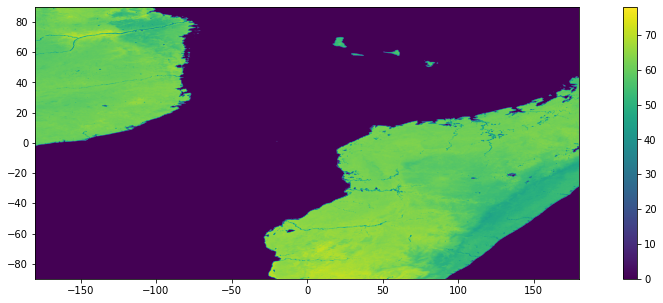

,longtitude,latitude,val
0,4154463.0,-1.082791e+06,61
1,4154463.0,-1.083041e+06,61
2,4154463.0,-1.083291e+06,61
3,4154463.0,-1.083541e+06,61
4,4154463.0,-1.083791e+06,61
...,...,...,...
29205199,5258393.0,-2.734514e+06,0
29205200,5258393.0,-2.734764e+06,0
29205201,5258393.0,-2.735014e+06,0
29205202,5258393.0,-2.735264e+06,0


In [166]:
get_worldclim_data("../raw_data/Madagascar_pH_0-5_mean.tif", True)

In [77]:
from PIL import Image
import rioxarray as rxr

In [86]:
#im = Image.open('Germany_pH_0-5_mean.tif')

In [87]:
#get_worldclim_data('Germany_pH_0-5_mean.tif')

# SoilGrids API

## Query a single pixel point on the soilgrids stack

layer: soilgrids layer name to be queried

depth: specific depth to be queried

values: statistical values

In [42]:
url = 'https://rest.isric.org/soilgrids/v2.0/properties/query'

In [56]:
longitude = 48.570066

In [57]:
latitude = 8.278059

In [58]:
params = {
    'lon': longitude,
    'lat': latitude,
    # options: https://www.isric.org/explore/soilgrids/faq-soilgrids -> 'Properties'
    'property': ['bdod', 'nitrogen', 'sand'],
    # six standard depth intervals
    'depth': ['0-5cm', '5-15cm'],
    'value': ['mean']
}

In [59]:
response = requests.get(url = url, params=params).json()

In [60]:
response['properties']['layers'][1]

{'name': 'nitrogen',
 'unit_measure': {'d_factor': 100,
  'mapped_units': 'cg/kg',
  'target_units': 'g/kg',
  'uncertainty_unit': ''},
 'depths': [{'range': {'top_depth': 0, 'bottom_depth': 5, 'unit_depth': 'cm'},
   'label': '0-5cm',
   'values': {'mean': 123}},
  {'range': {'top_depth': 5, 'bottom_depth': 15, 'unit_depth': 'cm'},
   'label': '5-15cm',
   'values': {'mean': 107}}]}

## Queries the WRB MostProbable vrt layer and the specific WRB class layers to extract probablity values

number_classes: Number of probability classes to return

In [63]:
url = 'https://rest.isric.org/soilgrids/v2.0/classification/query'

In [64]:
longitude = 48.570066

In [65]:
latitude = 8.278059

In [70]:
params = {
    'lon': longitude,
    'lat': latitude,
    'number_classes': 8
}

In [71]:
response = requests.get(url = url, params=params).json()

In [72]:
response

{'type': 'Point',
 'coordinates': [48.570066, 8.278059],
 'query_time_s': 0.3176867961883545,
 'wrb_class_name': 'Arenosols',
 'wrb_class_value': 4,
 'wrb_class_probability': [['Arenosols', 21],
  ['Leptosols', 19],
  ['Calcisols', 18],
  ['Fluvisols', 9],
  ['Cambisols', 6],
  ['Luvisols', 5],
  ['Vertisols', 5],
  ['Regosols', 4]]}